In [1]:
%pip install imbalanced-learn
%pip install xgboost
%pip install shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import seaborn as sns
import shap
import textwrap

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score, f1_score, average_precision_score, precision_recall_curve, make_scorer, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from scipy.stats import kurtosis, skew
from imblearn.under_sampling import EditedNearestNeighbours

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


c:\Desktop\coding\MYDAC-Curriculum\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../datasets/data.csv')

# Actual Model

Cross-validation ROC AUC scores:  [0.98295455 0.98560606 0.98295455 0.98711231 0.9878785 ]
Mean ROC AUC score:  0.9853011923633606


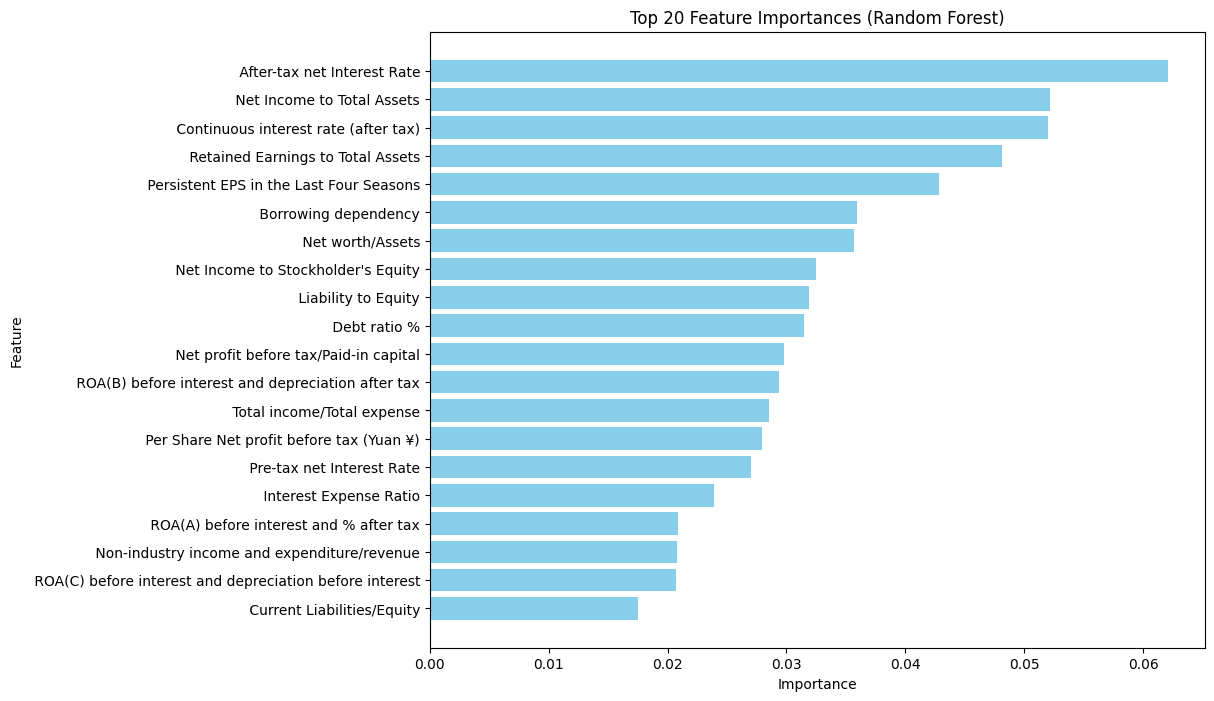

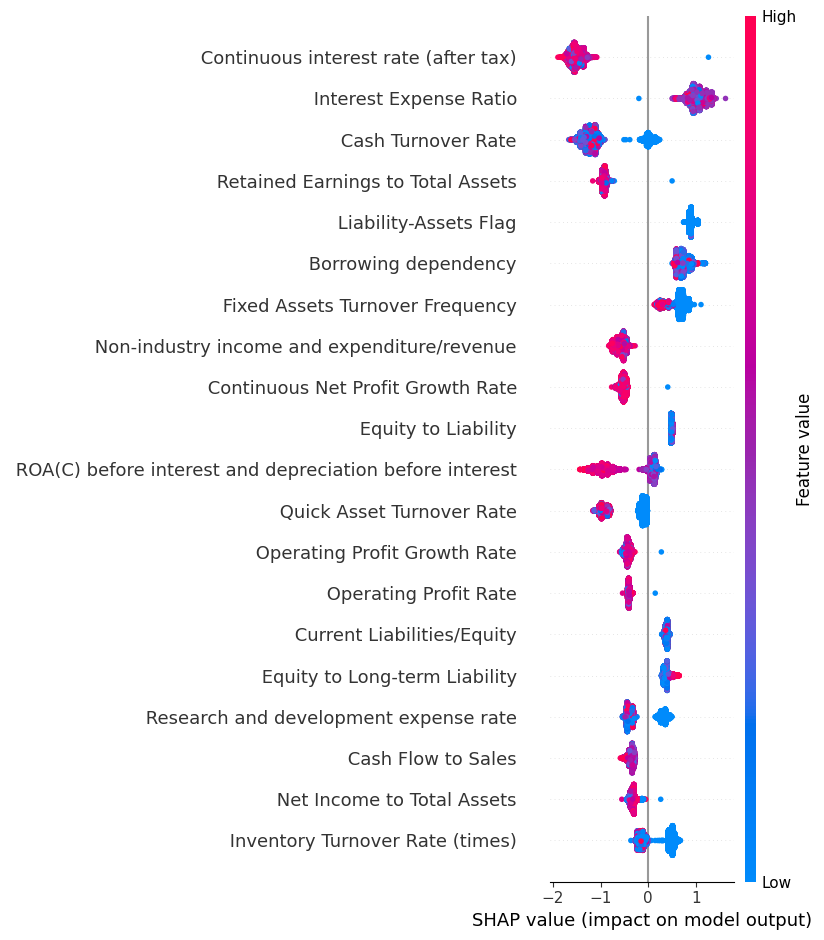


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1320
           1       0.98      1.00      0.99      1320

    accuracy                           0.99      2640
   macro avg       0.99      0.99      0.99      2640
weighted avg       0.99      0.99      0.99      2640



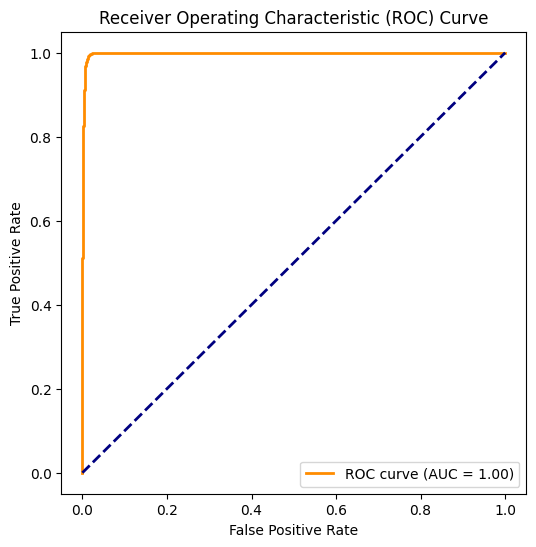

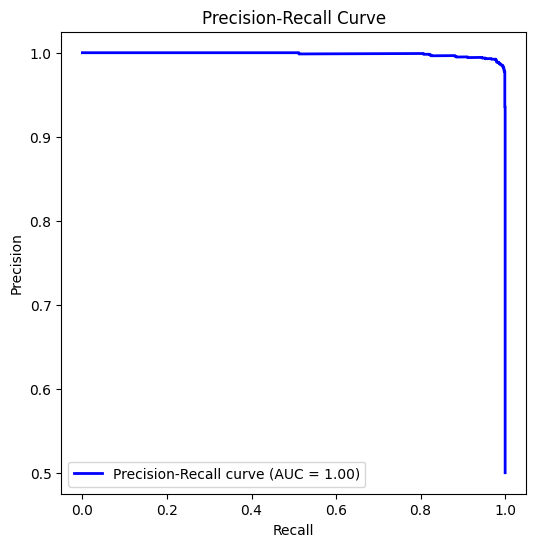


Confusion Matrix:


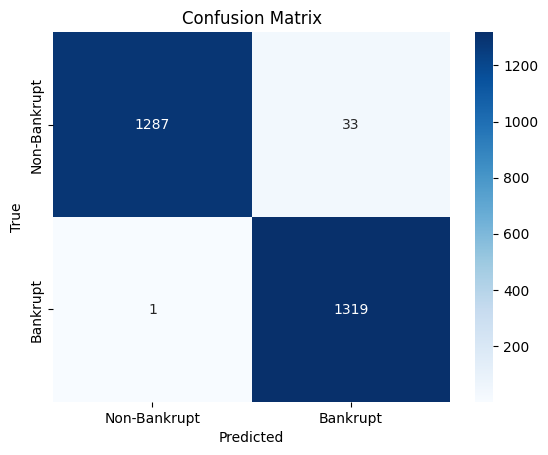

In [3]:
# Features and target
X = df.drop('Bankrupt?', axis=1)  # Features
y = df['Bankrupt?']  # Target (Bankrupt: 0 or 1)

# Handle missing values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X[X > 1e10] = np.nan
X[X < -1e10] = np.nan

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_imputed, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# Define models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Create a Voting Classifier to combine both models
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model)
], voting='soft')

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),      # Standardize features
    ('voting_model', voting_model)     # Use the voting model (ensemble)
])

# --- Cross-validation ---
# Set up StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the model pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),      # Standardize features
    ('voting_model', voting_model)     # Use the voting model (ensemble)
])

# Perform cross-validation using ROC AUC as the evaluation metric
roc_auc_scorer = make_scorer(roc_auc_score)

# Apply cross-validation and calculate the ROC AUC scores for each fold
cv_scores = cross_val_score(pipeline, X_res, y_res, cv=cv, scoring=roc_auc_scorer)

# Print out the cross-validation results
print("Cross-validation ROC AUC scores: ", cv_scores)
print("Mean ROC AUC score: ", cv_scores.mean())

# --- Train the pipeline ---
# Fit the pipeline first
pipeline.fit(X_train, y_train)

# --- Feature Importance from Random Forest ---
# Access Random Forest model inside the Voting Classifier (after fitting)
rf_model = pipeline.named_steps['voting_model'].named_estimators_['rf']

# Extract feature importance
rf_feature_importance = rf_model.feature_importances_

# Feature names and importance as a dataframe
feat_names = X.columns  # This should be defined before the feature importance step
feat_importance_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': rf_feature_importance
}).sort_values(by='Importance', ascending=False)

# Show the top N features (e.g., top 20)
top_n = 20
top_features = feat_importance_df.head(top_n)

# Visualize Random Forest feature importance
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')  # Correcting the barh command
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

# --- Feature Importance from XGBoost using SHAP ---
# Access XGBoost model inside the Voting Classifier (after fitting)
xgb_model = pipeline.named_steps['voting_model'].named_estimators_['xgb']

# Use SHAP for XGBoost feature importance
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_train, feature_names=feat_names)

# --- Evaluate the Model ---
y_pred = pipeline.predict(X_test)

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# --- ROC-AUC Curve ---
y_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# --- Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1320
           1       0.97      1.00      0.98      1320

    accuracy                           0.98      2640
   macro avg       0.98      0.98      0.98      2640
weighted avg       0.98      0.98      0.98      2640


Validation Confusion Matrix:
[[1277   43]
 [   6 1314]]
Validation ROC-AUC Score: 0.9979


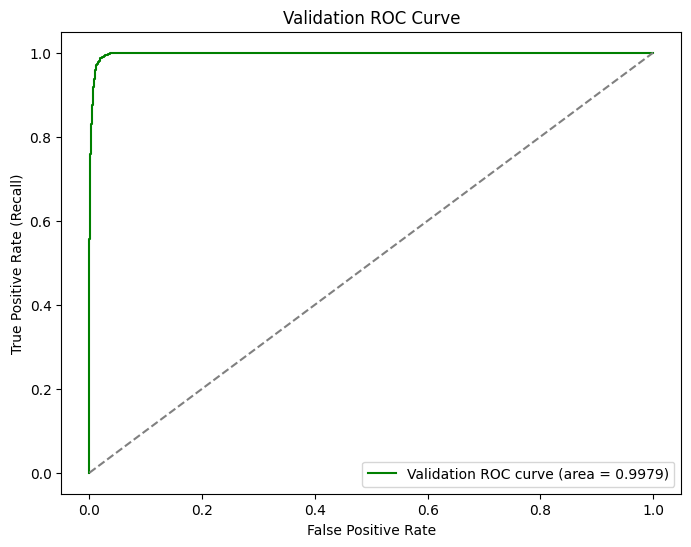

Test ROC-AUC Score: 0.9983


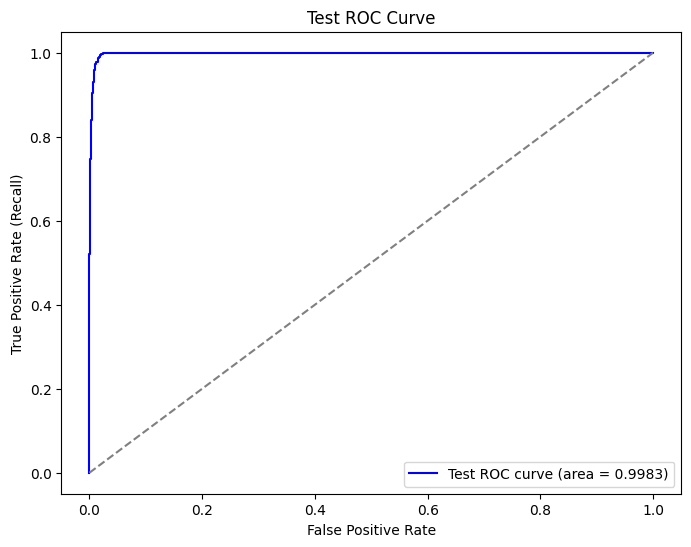

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1320
           1       0.97      1.00      0.98      1320

    accuracy                           0.98      2640
   macro avg       0.98      0.98      0.98      2640
weighted avg       0.98      0.98      0.98      2640


Test Confusion Matrix:
[[1281   39]
 [   2 1318]]
Cross-validation ROC AUC scores:  [0.98295455 0.98560606 0.98295455 0.98711231 0.9878785 ]
Mean ROC AUC score:  0.9853011923633606


ValueError: Found input variables with inconsistent numbers of samples: [10558, 7918]

In [4]:
# Features and target
X = df.drop('Bankrupt?', axis=1)  # Features
y = df['Bankrupt?']  # Target (Bankrupt: 0 or 1)

# Handle missing values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X[X > 1e10] = np.nan
X[X < -1e10] = np.nan

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_imputed, y)


# Split the data into training, validation, and testing sets
x_temp, x_val, y_temp, y_val = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)  # Reserve 20% for validation

x_train, x_test, y_train, y_test = train_test_split(
    x_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)  # 60% training, 20% testing (since 0.25 of 80% = 20%)


# Define models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)


# Create a Voting Classifier to combine both models
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model)
], voting='soft')

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),      # Standardize features
    ('voting_model', voting_model)     # Use the voting model (ensemble)
])

# Train the pipeline with the training data
pipeline.fit(x_train, y_train)

# Evaluate on the validation set
y_val_pred = pipeline.predict(x_val)
y_val_proba = pipeline.predict_proba(x_val)[:, 1]

# Calculate metrics for validation data
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Calculate ROC-AUC for validation data
roc_auc_val = roc_auc_score(y_val, y_val_proba)
print(f"Validation ROC-AUC Score: {roc_auc_val:.4f}")

# Plot ROC Curve for validation data
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='g', label=f'Validation ROC curve (area = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Validation ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the test set
y_pred = pipeline.predict(x_test)
y_proba = pipeline.predict_proba(x_test)[:, 1]

# Calculate ROC-AUC score for the test data
roc_auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve for test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='b', label=f'Test ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Test ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the test set
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
















# --- Cross-validation ---
# Set up StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the model pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),      # Standardize features
    ('voting_model', voting_model)     # Use the voting model (ensemble)
])

# Perform cross-validation using ROC AUC as the evaluation metric
roc_auc_scorer = make_scorer(roc_auc_score)

# Apply cross-validation and calculate the ROC AUC scores for each fold
cv_scores = cross_val_score(pipeline, X_res, y_res, cv=cv, scoring=roc_auc_scorer)

# Print out the cross-validation results
print("Cross-validation ROC AUC scores: ", cv_scores)
print("Mean ROC AUC score: ", cv_scores.mean())

# --- Train the pipeline ---
# Fit the pipeline first
pipeline.fit(X_train, y_train)

# --- Feature Importance from Random Forest ---
# Access Random Forest model inside the Voting Classifier (after fitting)
rf_model = pipeline.named_steps['voting_model'].named_estimators_['rf']

# Extract feature importance
rf_feature_importance = rf_model.feature_importances_

# Feature names and importance as a dataframe
feat_names = X.columns  # This should be defined before the feature importance step
feat_importance_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': rf_feature_importance
}).sort_values(by='Importance', ascending=False)

# Show the top N features (e.g., top 20)
top_n = 20
top_features = feat_importance_df.head(top_n)

# Visualize Random Forest feature importance
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')  # Correcting the barh command
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

# --- Feature Importance from XGBoost using SHAP ---
# Access XGBoost model inside the Voting Classifier (after fitting)
xgb_model = pipeline.named_steps['voting_model'].named_estimators_['xgb']

# Use SHAP for XGBoost feature importance
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_train, feature_names=feat_names)

# --- Evaluate the Model ---
y_pred = pipeline.predict(X_test)

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# --- ROC-AUC Curve ---
y_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# --- Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Optimise the code above and structure properly. 

In [ ]:
# Features and target
X = df.drop('Bankrupt?', axis=1)  # Features
y = df['Bankrupt?']  # Target (Bankrupt: 0 or 1)

# Handle missing values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X[X > 1e10] = np.nan
X[X < -1e10] = np.nan

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_imputed, y)


# Split the data into training, validation, and testing sets
x_temp, x_val, y_temp, y_val = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)  # Reserve 20% for validation

x_train, x_test, y_train, y_test = train_test_split(
    x_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)  # 60% training, 20% testing (since 0.25 of 80% = 20%)


# Define models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)


# Create a Voting Classifier to combine both models
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model)
], voting='soft')

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),      # Standardize features
    ('voting_model', voting_model)     # Use the voting model (ensemble)
])

# Train the pipeline with the training data
pipeline.fit(x_train, y_train)

# Evaluate on the validation set
y_val_pred = pipeline.predict(x_val)
y_val_proba = pipeline.predict_proba(x_val)[:, 1]

# Calculate metrics for validation data
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("\nValidation Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

# Calculate ROC-AUC for validation data
roc_auc_val = roc_auc_score(y_val, y_val_proba)
print(f"Validation ROC-AUC Score: {roc_auc_val:.4f}")

# Plot ROC Curve for validation data
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='g', label=f'Validation ROC curve (area = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Validation ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the test set
y_pred = pipeline.predict(x_test)
y_proba = pipeline.predict_proba(x_test)[:, 1]

# Calculate ROC-AUC score for the test data
roc_auc = roc_auc_score(y_test, y_proba)
print(f"Test ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve for test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='b', label=f'Test ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Test ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Evaluate the model on the test set
print("Test Classification Report:")
print(classification_report(y_test, y_pred))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
















# --- Cross-validation ---
# Set up StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the model pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),      # Standardize features
    ('voting_model', voting_model)     # Use the voting model (ensemble)
])

# Perform cross-validation using ROC AUC as the evaluation metric
roc_auc_scorer = make_scorer(roc_auc_score)

# Apply cross-validation and calculate the ROC AUC scores for each fold
cv_scores = cross_val_score(pipeline, X_res, y_res, cv=cv, scoring=roc_auc_scorer)

# Print out the cross-validation results
print("Cross-validation ROC AUC scores: ", cv_scores)
print("Mean ROC AUC score: ", cv_scores.mean())

# --- Train the pipeline ---
# Fit the pipeline first
pipeline.fit(X_train, y_train)

# --- Feature Importance from Random Forest ---
# Access Random Forest model inside the Voting Classifier (after fitting)
rf_model = pipeline.named_steps['voting_model'].named_estimators_['rf']

# Extract feature importance
rf_feature_importance = rf_model.feature_importances_

# Feature names and importance as a dataframe
feat_names = X.columns  # This should be defined before the feature importance step
feat_importance_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': rf_feature_importance
}).sort_values(by='Importance', ascending=False)

# Show the top N features (e.g., top 20)
top_n = 20
top_features = feat_importance_df.head(top_n)

# Visualize Random Forest feature importance
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')  # Correcting the barh command
plt.title(f'Top {top_n} Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

# --- Feature Importance from XGBoost using SHAP ---
# Access XGBoost model inside the Voting Classifier (after fitting)
xgb_model = pipeline.named_steps['voting_model'].named_estimators_['xgb']

# Use SHAP for XGBoost feature importance
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_train, feature_names=feat_names)

# --- Evaluate the Model ---
y_pred = pipeline.predict(X_test)

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# --- ROC-AUC Curve ---
y_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# --- Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# --- Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Optimising code for clarity and presentation. 

In [ ]:
# --- Utility Functions ---

# --- Helper Function for Metrics and Plots ---
def evaluate_model(pipeline, X, y, dataset_name="Dataset"):
    """
    Evaluate a trained pipeline on a dataset and display performance metrics.
    Outputs classification report, confusion matrix, and ROC-AUC/PR curves.
    """
    y_pred = pipeline.predict(X)
    y_proba = pipeline.predict_proba(X)[:, 1]
    
    # Classification Report
    print(f"\n{dataset_name} Classification Report:")
    print(classification_report(y, y_pred))
    
    # Confusion Matrix
    print(f"\n{dataset_name} Confusion Matrix:")
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Bankrupt', 'Bankrupt'], 
                yticklabels=['Non-Bankrupt', 'Bankrupt'])
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title(f'{dataset_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y, y_proba)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
    plt.title(f'{dataset_name} Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.show()
    
    return {"roc_auc": roc_auc, "pr_auc": pr_auc}


def plot_roc_curve(fpr, tpr, auc_score, title):
    """Plots ROC curve."""
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()


def plot_pr_curve(precision, recall, pr_auc, title):
    """Plots Precision-Recall curve."""
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.show()


# --- Data Preparation ---
# Features and target
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

# Handle missing values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X[X.abs() > 1e10] = np.nan  # Combine extreme outlier handling
X_imputed = SimpleImputer(strategy='median').fit_transform(X)

# SMOTE for oversampling
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_imputed, y)

# Split into training, validation, and test sets
x_temp, x_val, y_temp, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
x_train, x_test, y_train, y_test = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# --- Model Definition ---
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
voting_model = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model)], voting='soft')

pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('voting_model', voting_model)
])

# --- Training ---
pipeline.fit(x_train, y_train)

# --- Validation ---
y_val_proba = pipeline.predict_proba(x_val)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_val_proba)
print(f"Validation ROC-AUC Score: {roc_auc_val:.4f}")

fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
plot_roc_curve(fpr_val, tpr_val, roc_auc_val, 'Validation ROC Curve')

# --- Testing ---
y_test_proba = pipeline.predict_proba(x_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_test_proba)
print(f"Test ROC-AUC Score: {roc_auc_test:.4f}")

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
plot_roc_curve(fpr_test, tpr_test, roc_auc_test, 'Test ROC Curve')

precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc = auc(recall, precision)
plot_pr_curve(precision, recall, pr_auc, 'Test Precision-Recall Curve')

# --- Feature Importance ---
rf_model = pipeline.named_steps['voting_model'].named_estimators_['rf']
feat_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feat_importance_df['Feature'][:20], feat_importance_df['Importance'][:20], color='skyblue')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

# --- SHAP for XGBoost ---
xgb_model = pipeline.named_steps['voting_model'].named_estimators_['xgb']
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, feature_names=X.columns)


# --- Evaluate on Validation Set ---
print("Validation Set Evaluation:")
validation_metrics = evaluate_model(pipeline, x_val, y_val, dataset_name="Validation")

# --- Evaluate on Test Set ---
print("\nTest Set Evaluation:")
test_metrics = evaluate_model(pipeline, x_test, y_test, dataset_name="Test")



In [ ]:
# --- Utility Functions ---

# --- Helper Function for Metrics and Plots ---
def evaluate_model(pipeline, X, y, dataset_name="Dataset"):
    """
    Evaluate a trained pipeline on a dataset and display performance metrics.
    Outputs classification report, confusion matrix, and ROC-AUC/PR curves.
    """
    y_pred = pipeline.predict(X)
    y_proba = pipeline.predict_proba(X)[:, 1]
    
    # Classification Report
    print(f"\n{dataset_name} Classification Report:")
    print(classification_report(y, y_pred))
    
    # Confusion Matrix
    print(f"\n{dataset_name} Confusion Matrix:")
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Bankrupt', 'Bankrupt'], 
                yticklabels=['Non-Bankrupt', 'Bankrupt'])
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title(f'{dataset_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y, y_proba)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
    plt.title(f'{dataset_name} Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.show()
    
    return {"roc_auc": roc_auc, "pr_auc": pr_auc}


def plot_roc_curve(fpr, tpr, auc_score, title):
    """Plots ROC curve."""
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()


def plot_pr_curve(precision, recall, pr_auc, title):
    """Plots Precision-Recall curve."""
    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.show()


# --- Data Preparation ---
# Features and target
X = df.drop('Bankrupt?', axis=1)
y = df['Bankrupt?']

# Handle missing values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X[X.abs() > 1e10] = np.nan  # Combine extreme outlier handling
X_imputed = SimpleImputer(strategy='median').fit_transform(X)

# SMOTE for oversampling
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_imputed, y)

# Split into training, validation, and test sets
x_temp, x_val, y_temp, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
x_train, x_test, y_train, y_test = train_test_split(x_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# --- Model Definition ---
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)
voting_model = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model)], voting='soft')

pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('voting_model', voting_model)
])

# --- Cross-Validation Setup ---
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate pipeline using cross-validation
cv_scores = cross_val_score(pipeline, X_res, y_res, scoring='roc_auc', cv=cv, n_jobs=-1)

print("\nCross-Validation ROC-AUC Scores:")
print(cv_scores)
print(f"Mean ROC-AUC: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

# --- Training and Final Evaluation on Test Set ---
pipeline.fit(x_train, y_train)  # Retrain on full training set for final evaluation

# --- Validation ---
y_val_proba = pipeline.predict_proba(x_val)[:, 1]
roc_auc_val = roc_auc_score(y_val, y_val_proba)
print(f"Validation ROC-AUC Score: {roc_auc_val:.4f}")

fpr_val, tpr_val, _ = roc_curve(y_val, y_val_proba)
plot_roc_curve(fpr_val, tpr_val, roc_auc_val, 'Validation ROC Curve')

# --- Testing ---
y_test_proba = pipeline.predict_proba(x_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_test_proba)
print(f"Test ROC-AUC Score: {roc_auc_test:.4f}")

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
plot_roc_curve(fpr_test, tpr_test, roc_auc_test, 'Test ROC Curve')

precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc = auc(recall, precision)
plot_pr_curve(precision, recall, pr_auc, 'Test Precision-Recall Curve')

# --- Feature Importance ---
rf_model = pipeline.named_steps['voting_model'].named_estimators_['rf']
feat_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feat_importance_df['Feature'][:20], feat_importance_df['Importance'][:20], color='skyblue')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

# --- SHAP for XGBoost ---
xgb_model = pipeline.named_steps['voting_model'].named_estimators_['xgb']
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, feature_names=X.columns)


# --- Evaluate on Validation Set ---
print("Validation Set Evaluation:")
validation_metrics = evaluate_model(pipeline, x_val, y_val, dataset_name="Validation")

# --- Evaluate on Test Set ---
print("\nTest Set Evaluation:")
test_metrics = evaluate_model(pipeline, x_test, y_test, dataset_name="Test")
